##### Import Stuff

In [1]:
%matplotlib inline
from importlib import reload
import utils; reload(utils)
from utils import *

Using cuDNN version 5105 on context None
Preallocating 2867/4095 Mb (0.700000) on cuda0
Mapped name None to device cuda0: GeForce GTX 650 (0000:01:00.0)
Using Theano backend.


In [2]:
%matplotlib inline

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import dicom
import scipy.misc

import SimpleITK as sitk
import time
from os import listdir, walk

## Load images and get spacing for images

In [4]:
'''
This function reads a '.mhd' file using SimpleITK and return the image array, 
origin and spacing of the image.
'''
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)
    
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    
    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    
    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    
    return ct_scan, origin, spacing

'''
This function is used to convert the world coordinates to voxel coordinates using 
the origin and spacing of the ct_scan
'''
def world_2_voxel(world_coordinates, origin, spacing):
    stretched_voxel_coordinates =  np.absolute(world_coordinates - origin)
    voxel_coordinates = stretched_voxel_coordinates / spacing
    return voxel_coordinates

'''
This function is used to convert the voxel coordinates to world coordinates using 
the origin and spacing of the ct_scan.
'''
def voxel_2_world(voxel_coordinates, origin, spacing):
    stretched_voxel_coordinates = voxel_coordinates * spacing
    world_coordinates = stretched_voxel_coordinates + origin
    return world_coordinates

def load_itk_spacing(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)
    
      
    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    
    return spacing

def normalizePlanes(npzarray):
    maxHU = 400.
    minHU = -1000.
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [5]:
data_path = "/Volumes/Backups/data/LUNA16/"

In [129]:
patient_slice = load_itk(data_path + "subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886.mhd")

In [6]:
annotations = pd.read_csv(data_path + "annotations.csv")

In [7]:
candidates = pd.read_csv(data_path + "candidatesworst.csv")

In [8]:
candidates

seriesuid     coordX     coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644...  75.721224  92.887331   

       coordZ  class  
0 -119.270564      1

In [9]:
annotations.ix[annotations['diameter_mm'].idxmax()]['seriesuid']


'1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886'

In [10]:
patient_slice



NameError: name 'patient_slice' is not defined

In [11]:
patient_slice[0][0][0]


NameError: name 'patient_slice' is not defined

In [12]:
plt.imshow(patient_slice[0][0])


NameError: name 'patient_slice' is not defined

In [13]:
plt.show()


In [14]:
patient_slice[0][0][300]

NameError: name 'patient_slice' is not defined

In [15]:
patient_slice[2]

NameError: name 'patient_slice' is not defined

In [16]:
type(image)

module

In [17]:
image = sitk.ReadImage(data_path + "subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886.mhd")

In [18]:
print (image.GetSize())

(512, 512, 123)


In [19]:
print (image.GetOrigin())
print (image.GetSpacing())
print (image.GetDirection())

print (image.GetNumberOfComponentsPerPixel())

(-212.199997, -210.0, -338.0)
(0.8203120231628418, 0.8203120231628418, 2.5)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
1


In [20]:
sitk.GetArrayFromImage(image)[0:3].shape

(3, 512, 512)

In [21]:
sitk.GetArrayFromImage(image).shape

(123, 512, 512)

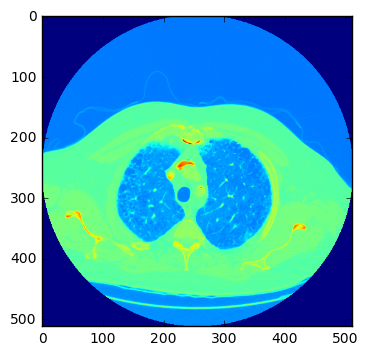

In [22]:
plt.imshow(sitk.GetArrayFromImage(image)[99])

In [23]:
image.GetSpacing()

(0.8203120231628418, 0.8203120231628418, 2.5)

In [24]:
image_array=sitk.GetArrayFromImage(image)

In [25]:
(image_array).shape


(123, 512, 512)

In [26]:
def get_5dslice(d_image,slice_loc):
    slice = sitk.GetArrayFromImage(d_image)[slice_loc-2:slice_loc+3]
    return slice


In [27]:
new_image = get_5dslice(image,91)

In [28]:
def resample_image(image, image_array, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    
    real_spacing =  image.GetSpacing()
    spacing = np.array(np.roll(real_spacing,1), dtype=np.float32)

    resize_factor = spacing / new_spacing
    print(spacing)
    new_real_shape = image_array.shape * resize_factor
    new_shape = np.round(new_real_shape)
    print(new_shape)
    real_resize_factor = new_shape / image_array.shape
    new_spacing = spacing / real_resize_factor
    print(new_spacing)
    image_array2 = scipy.ndimage.interpolation.zoom(image_array, real_resize_factor, mode='nearest')
    
    return image_array2, new_spacing


In [29]:
%time outcome = resample_image(image,new_image)

[ 2.5     0.8203  0.8203]
[  12.  420.  420.]
[ 1.0417  1.      1.    ]
CPU times: user 1.3 s, sys: 16.1 ms, total: 1.31 s
Wall time: 1.36 s


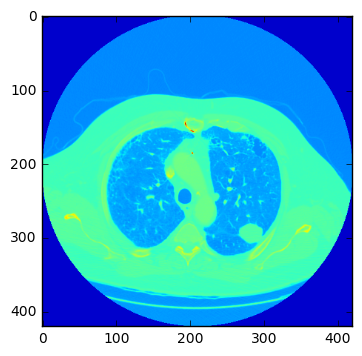

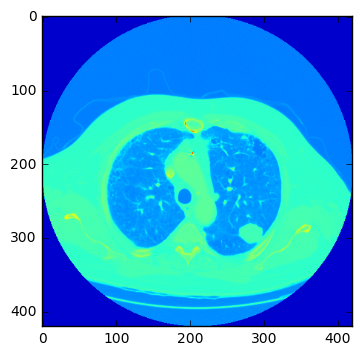

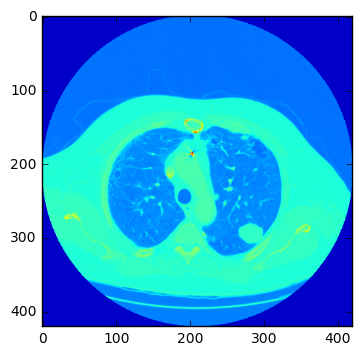

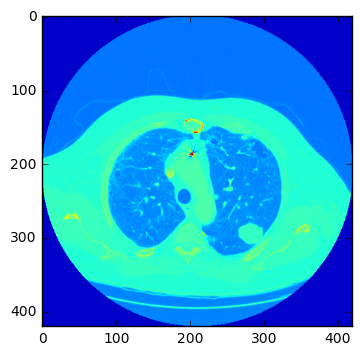

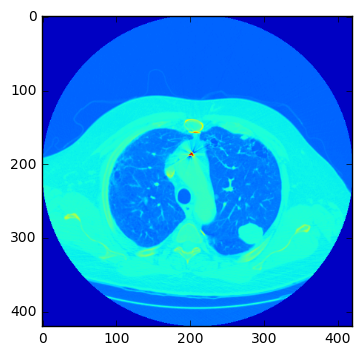

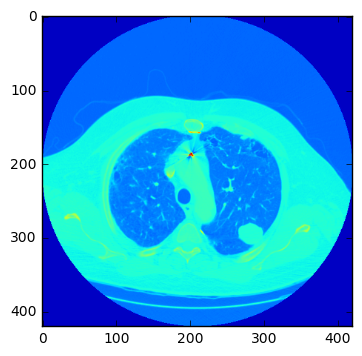

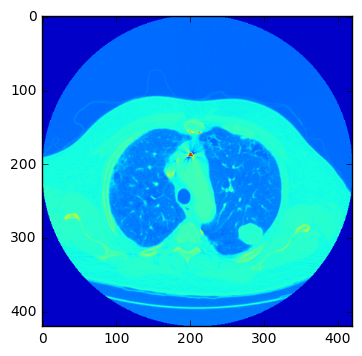

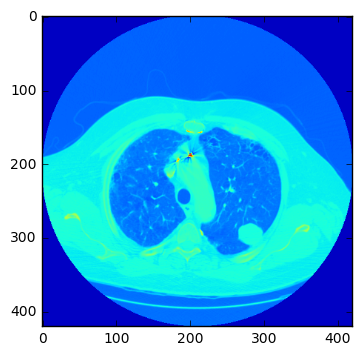

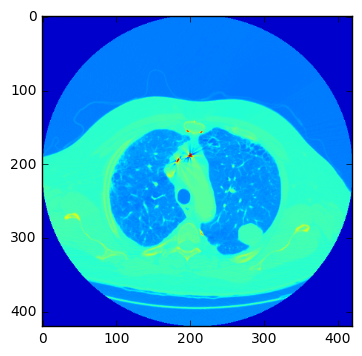

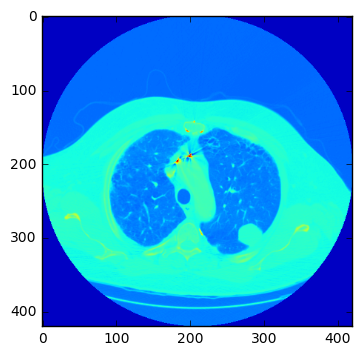

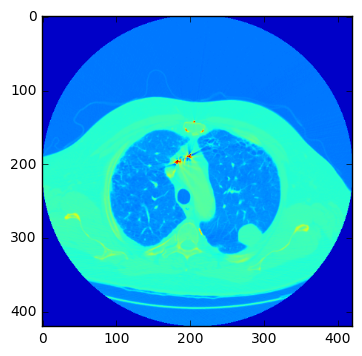

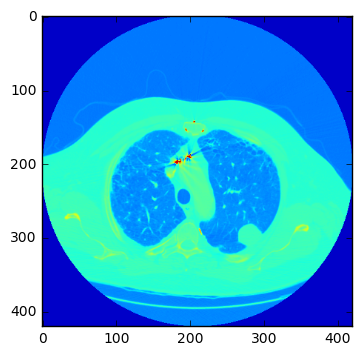

In [30]:
for i in range(12):
    plt.imshow(outcome[0][i])
    plt.show()

In [31]:
def get_3dslice(d_image,slice_loc):
    slice = sitk.GetArrayFromImage(d_image)[slice_loc-1:slice_loc+2]
    return slice

In [32]:
get_3dslice(image,4).shape

(3, 512, 512)

In [33]:
def create_slice_array(image):
    num_layers = image.GetSize()[2]-2
    print(num_layers)
    slice_array = np.zeros((image.GetSize()[2]-2,3,512,512))
    for i in range(num_layers):
        slice =  np.zeros((3,512,512))
        slice_array[i] = get_3dslice(image,i+1)
    slice_array = slice_array.transpose(0,2,3,1)
    return slice_array

In [34]:
%time color_array = create_slice_array(image)

121
CPU times: user 2.12 s, sys: 2.15 s, total: 4.27 s
Wall time: 4.35 s


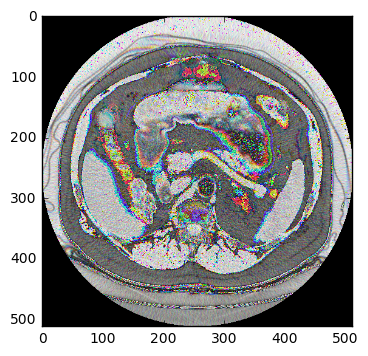

In [35]:
color_array[92].shape
plt.imshow(color_array[0])

In [36]:
candidates.values

array([['1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', 75.7212243102,
        92.88733103940001, -119.27056405200001, 1]], dtype=object)

In [37]:
annotations.loc[annotations['diameter_mm'].idxmax(),'coordZ']

-109.74672379999998

In [38]:
annotations

seriesuid      coordX  \
0     1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421   
1     1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651   
2     1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017   
3     1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824   
4     1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547   
5     1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...   90.931713   
6     1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...   89.540769   
7     1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028...   81.509646   
8     1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408...  105.055792   
9     1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760... -124.834262   
10    1.3.6.1.4.1.14519.5.2.1.6279.6001.105495028985... -106.901301   
11    1.3.6.1.4.1.14519.5.2.1.6279.6001.106164978370...    2.263816   
12    1.3.6.1.4.1.14519.5.2.1.6279.6001.106379658920...  -70.550889   
13    1.3.6.1.4.1.14519.5.2.1.6279.6001.106379658920...  -70.660628   
14    1.3.6.1.4.1.14519.5.2.1.6279.6001.106630482085...  -96.439534   
15    1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982...  -57.087180   
16    1.3.6.1.4.1.14519.5.2.1.6279.6001.107109359065...  -98.135977   
17    1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259...  122.078920   
18    1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259...  100.932273   
19    1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259...  -46.783729   
20    1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259...  -69.126568   
21    1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259... -108.072812   
22    1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259...   82.229181   
23    1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896... -100.567944   
24    1.3.6.1.4.1.14519.5.2.1.6279.6001.108231420525...   42.574154   
25    1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...   46.188539   
26    1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...   36.392044   
27    1.3.6.1.4.1.14519.5.2.1.6279.6001.110678335949...  -38.096020   
28    1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...  136.434059   
29    1.3.6.1.4.1.14519.5.2.1.6279.6001.111258527162...  -80.951859   
...                                                 ...         ...   
1156  1.3.6.1.4.1.14519.5.2.1.6279.6001.931383239747...  -87.920377   
1157  1.3.6.1.4.1.14519.5.2.1.6279.6001.935683764293...   64.133938   
1158  1.3.6.1.4.1.14519.5.2.1.6279.6001.935683764293...  -74.891965   
1159  1.3.6.1.4.1.14519.5.2.1.6279.6001.939152384493...  107.405426   
1160  1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251...  -46.949664   
1161  1.3.6.1.4.1.14519.5.2.1.6279.6001.944888107209...   40.314795   
1162  1.3.6.1.4.1.14519.5.2.1.6279.6001.946129570505...  121.908760   
1163  1.3.6.1.4.1.14519.5.2.1.6279.6001.948414623428...  -84.151846   
1164  1.3.6.1.4.1.14519.5.2.1.6279.6001.948414623428...  -42.465222   
1165  1.3.6.1.4.1.14519.5.2.1.6279.6001.952265563663...  -48.062130   
1166  1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308... -112.745883   
1167  1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308...  -40.211068   
1168  1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308...   87.076660   
1169  1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308...   55.972756   
1170  1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308...  109.200675   
1171  1.3.6.1.4.1.14519.5.2.1.6279.6001.961063442349...  -72.860803   
1172  1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561...   35.106203   
1173  1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561...   56.350667   
1174  1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561...  -70.913535   
1175  1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561...  -75.558882   
1176  1.3.6.1.4.1.14519.5.2.1.6279.6001.970264865033... -109.428509   
1177  1.3.6.1.4.1.14519.5.2.1.6279.6001.970428941353... -114.213070   
1178  1.3.6.1.4.1.14519.5.2.1.6279.6001.970428941353... -116.037038   
1179  1.3.6.1.4.1.14519.5.2.1.6279.6001.975426625618...   52.996021   
1180  1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707... -104.441975   

In [39]:
annotations['diameter_mm'].max()

32.270030249999998

In [40]:
#mhdfiles = []
#spacing_list = []
#
#for dirName, subdirList, fileList in os.walk(data_path):
#    for subdirName in subdirList:
#        if subdirName.startswith('sub'):
#            print (subdirName)
#            for dirName2,subdirList2,fileList2 in os.walk(dirName + subdirName):
#                for file in fileList2:
#                    if file.endswith('mhd'):
#                        mhdfiles.append(dirName2 + '/' +file)
#                        templist = (load_itk_spacing(dirName2 + '/' +file))
#                        tempfilelist = [dirName2 + '/' + file, file]
#                        for x in templist:
#                            tempfilelist.append(x)
#                        spacing_list.append(tempfilelist)

In [41]:
#spacing_df = pd.DataFrame(spacing_list)

In [42]:
#spacing_df.columns = ["file_loc","seriesuid",'dz','dx','dy']

In [43]:
#spacing_df['seriesuid'].replace(regex=True,inplace=True,to_replace=r'.mhd',value=r'')


In [44]:
#spacing_df.to_csv('spacing_df.csv', index=False)

In [45]:
spacing_df = pd.read_csv('spacing_df.csv')

In [46]:
pd.options.display.max_colwidth = 100

In [47]:
spacing_df.hist(column='dz')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1531e7518>]], dtype=object)

In [48]:
candidates.head()


seriesuid  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886   

      coordX     coordY      coordZ  class  
0  75.721224  92.887331 -119.270564      1

In [49]:
annotations.head()

seriesuid  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405   

       coordX      coordY      coordZ  diameter_mm  
0 -128.699421 -175.319272 -298.387506     5.651471  
1  103.783651 -211.925149 -227.121250     4.224708  
2   69.639017 -140.944586  876.374496     5.786348  
3  -24.013824  192.102405 -391.081276     8.143262  
4    2.441547  172.464881 -405.493732    18.545150

In [50]:
candidates_full = pd.read_csv(data_path + "candidates.csv")

In [51]:
candidates_tumor = candidates_full.loc[candidates_full['class'] == 1]

In [52]:
candidates_full.head()

seriesuid  coordX  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860  -56.08   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860   53.21   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860  103.66   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860  -33.66   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860  -32.25   

   coordY  coordZ  class  
0  -67.85 -311.92      0  
1 -244.41 -245.17      0  
2 -121.80 -286.62      0  
3  -72.75 -308.41      0  
4  -85.36 -362.51      0

In [53]:
len (candidates_tumor)

1351

In [54]:
candidates_tumor.head()

seriesuid  \
13    1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860   
78    1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860   
1303  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208   
3050  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405   
3052  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405   

          coordX      coordY      coordZ  class  
13    104.164804 -211.685591 -227.011364      1  
78   -128.940000 -175.040000 -297.870000      1  
1303   70.190000 -140.930000  877.680000      1  
3050   89.320000  190.840000 -516.820000      1  
3052   94.930000  153.030000 -429.910000      1

In [55]:
candidates_class1_df = pd.merge(spacing_df,candidates_tumor, on='seriesuid',how='outer').dropna()

In [56]:
candidates_class1_df[candidates_class1_df.seriesuid == '1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886'].head()

file_loc  \
255  /Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.2879662446442806907370192...   
256  /Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.2879662446442806907370192...   
257  /Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.2879662446442806907370192...   
258  /Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.2879662446442806907370192...   
259  /Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.2879662446442806907370192...   

                                                            seriesuid   dz  \
255  1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886  2.5   
256  1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886  2.5   
257  1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886  2.5   
258  1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886  2.5   
259  1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886  2.5   

           dx        dy     coordX     coordY      coordZ  class  
255  0.820312  0.820312  64.102928  84.984149  -95.261090    1.0  
256  0.820312  0.820312  66.128383  91.435874 -121.999168    1.0  
257  0.820312  0.820312  58.106060  81.308898  -97.816037    1.0  
258  0.820312  0.820312  67.614517  85.025260 -109.808442    1.0  
259  0.820312  0.820312  75.721224  92.887331 -119.270564    1.0

In [57]:
 candidates_class1_df.ix[[517]].iterrows()

<generator object DataFrame.iterrows at 0x152a09048>

In [58]:
def get_voxel_coord(Vc, Vw):
    if (Vc-Vw/2) > 0:
        return (Vc-Vw/2)
    else:
        return 0

In [59]:
def get_voxel_slice_coord(Vc, Vw):
    if (Vc-Vw/2) > 0:
        Vc1 = (Vc-Vw/2)
        Vc2 = (Vc+Vw/2)
        if (Vc2 > 512):
            Vc1 = 512 - Vw
            Vc2 = 512
        return (int(Vc1),int(Vc2))
    else:
        return (0,Vw)
    

In [60]:
get_voxel_slice_coord(voxelCoord[1],25)

NameError: name 'voxelCoord' is not defined

In [61]:
voxelCoord[0]

NameError: name 'voxelCoord' is not defined

In [62]:
print(numpyImage[int(voxelCoord[0]),(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[0]):(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[1]),(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[0]):(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[1])].shape)

NameError: name 'numpyImage' is not defined

In [63]:
numpyImage.shape

NameError: name 'numpyImage' is not defined

In [64]:
candidates_class1_df


file_loc  \
1     /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1081978958964468961600487...   
2     /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1090025255245222256586098...   
3     /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1090025255245222256586098...   
4     /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1090025255245222256586098...   
5     /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1111721656746612213819205...   
7     /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1241544610489291537677438...   
9     /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1262645789317782588903717...   
10    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1280239026512339865923783...   
11    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1290559776373386397416958...   
12    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1304385508908165509947391...   
13    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1349968725834973829540244...   
14    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1349968725834973829540244...   
15    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1349968725834973829540244...   
16    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1349968725834973829540244...   
17    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1377632127521540819772612...   
18    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1377632127521540819772612...   
19    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1377632127521540819772612...   
20    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1377632127521540819772612...   
21    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1377632127521540819772612...   
23    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1392587778987466933658770...   
25    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1410696617006700429606784...   
28    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1546773963546411502800132...   
29    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1546773963546411502800132...   
30    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1874517152050854036235952...   
31    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1874517152050854036235952...   
32    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1874517152050854036235952...   
33    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1882098896863631598537152...   
34    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1883763498047619882175977...   
35    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1883763498047619882175977...   
36    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1883763498047619882175977...   
...                                                                                                   ...   
1611  /Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.3099019138477141563679817...   
1612  /Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.3114761287319581429819416...   
1613  /Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.3121279337229852048087066...   
1614  /Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.3121279337229852048087066...   
1615  /Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.3121279337229852048087066...   
1616  /Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2

In [65]:
for index,row in  candidates_class1_df.iterrows(): 
    numpyImage, numpyOrigin, numpySpacing = load_itk(row[0])
    print ("numpyImageShape: " + str(numpyImage.shape))
    print ("numpyOrigin: " + str(numpyOrigin))
    print ("numpySpacing: " + str(numpySpacing))
    print (row[0])
    worldCoord =([row[7],row[6],row[5]])
    voxelCoord = world_2_voxel(worldCoord, numpyOrigin, numpySpacing)
    voxelWidth = 224
    print("index " + str(index))
    print(int(voxelCoord[0]),(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[0]),(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[1]),(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[0]),(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[1]))
    print(numpyImage[int(voxelCoord[0]),(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[0]):(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[1]),(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[0]):(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[1])].shape)
    patch = numpyImage[int(voxelCoord[0]),(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[0]):(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[1]),(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[0]):(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[1])]
    print(patch.shape)

numpyImageShape: (119, 512, 512)
numpyOrigin: [-313.75 -190.   -182.5 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
index 1
33 235 459 0 224
(224, 224)
(224, 224)
numpyImageShape: (161, 512, 512)
numpyOrigin: [-194.  -108.3 -187.7]
numpySpacing: [ 1.25    0.5488  0.5488]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
index 2
56 227 451 288 512
(224, 224)
(224, 224)
numpyImageShape: (161, 512, 512)
numpyOrigin: [-194.  -108.3 -187.7]
numpySpacing: [ 1.25    0.5488  0.5488]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
index 3
67 180 404 288 512
(224, 224)
(224, 224)
numpyImageShape: (161, 512, 512)
numpyOrigin: [-194.  -108.3 -187.7]
numpySpacing: [ 1.25    0.5488  0.5488]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808

KeyboardInterrupt: 

In [ ]:
# get candidates class 1
for   index,row in  candidates_class1_df.iterrows():
    numpyImage, numpyOrigin, numpySpacing = load_itk(row[0])
    print ("numpyImageShape: " + str(numpyImage.shape))
    print ("numpyOrigin: " + str(numpyOrigin))
    print ("numpySpacing: " + str(numpySpacing))
    print (row[0])
    worldCoord =([row[7],row[6],row[5]])
    voxelCoord = world_2_voxel(worldCoord, numpyOrigin, numpySpacing)
    voxelWidth = 224
    print("index " + str(index))
    print(voxelCoord[0],(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[0]),(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[1]),(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[0]),(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[1]))
    print(numpyImage[int(voxelCoord[0]),(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[0]):(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[1]),(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[0]):(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[1])].shape)
    patch = numpyImage[int(voxelCoord[0]),(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[0]):(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[1]),(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[0]):(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[1])]
    print(patch.shape)
    patch = normalizePlanes(patch)*255
    print (voxelCoord)
    print ('data')
    print ("worldCoord: " + str(worldCoord))
    print ("voxelCoord: " + str(voxelCoord))
    print ("numpyOrigin: " + str(numpyOrigin))
    outputDir = 'patches/patches1/'
    file_name = (data_path + 'patches/224x224/patches1/' + row[1] +'_'+ str(index) +'_'+ str(patch.shape[0]) +'x'+ str(patch.shape[1]) + '.bc')
    print (file_name)
    
    save_array(file_name, patch)
#    plt.imshow(patch*255, cmap='gray', vmin=0.,vmax=255.)
#    plt.show()
#    full_img = numpyImage[voxelCoord[0]]
#    full_img = normalizePlanes(full_img)
#    plt.imshow(full_img*255, cmap='gray', vmin=0.,vmax=255.)
#    plt.show()

In [ ]:
candidates_class1_df

In [27]:
candidates_class1_df[0:2]

file_loc  \
1  /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1081978958964468961600487...   
2  /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1090025255245222256586098...   

                                                          seriesuid    dz  \
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492  2.50   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059  1.25   

         dx        dy  coordX  coordY  coordZ  class  
1  0.742188  0.742188 -100.46   68.01 -230.55    1.0  
2  0.548828  0.548828   36.54   78.10 -122.92    1.0

In [38]:
test_image_good = load_array('/Volumes/Backups/data/LUNA16/patches/224x224/patches1/1.3.6.1.4.1.14519.5.2.1.6279.6001.280072876841890439628529365478_462_224x224.bc')
        

In [39]:
test_image_good.shape

(224, 224)

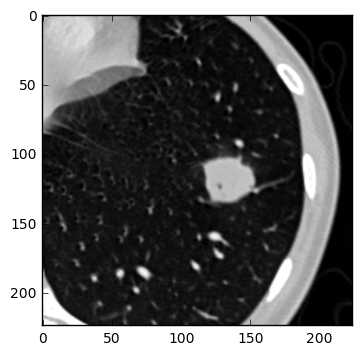

In [40]:
plt.imshow(test_image_good,cmap=plt.cm.gray)

In [67]:
candidates_class0 = candidates_full.loc[candidates_full['class'] == 0]

In [68]:
candidates_class0['seriesuid'].value_counts().hist()

In [69]:
spacing_df.head()


file_loc  \
0  /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1057566580315150620007448...   
1  /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1081978958964468961600487...   
2  /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1090025255245222256586098...   
3  /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1111721656746612213819205...   
4  /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1227639138967614943718226...   

                                                          seriesuid     dz  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260  2.500   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492  2.500   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059  1.250   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987  0.625   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720  2.500   

         dx        dy  
0  0.761719  0.761719  
1  0.742188  0.742188  
2  0.548828  0.548828  
3  0.742188  0.742188  
4  0.615234  0.615234

In [70]:
candidates_class0_df = pd.merge( spacing_df[['file_loc','seriesuid']],candidates_class0, on=['seriesuid'],how = 'inner')

In [71]:
len(candidates_class0_df)

549714

In [72]:
candidates_class0_short_df= (candidates_class0_df.sample(n=15000))

In [73]:
candidates_class0_short_df.head(10)

file_loc  \
221890  /Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.1047809061315356258728408...   
455643  /Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.2060971133430596122475030...   
49471   /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.7164986951014476655806104...   
132412  /Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.2175899364219866381394514...   
276658  /Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.1064198504060566348775795...   
54281   /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.9053719585886604102403983...   
170320  /Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.1279651615640336051778030...   
342132  /Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.1610675142251099995863626...   
419408  /Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.2801258031529247783883469...   
116788  /Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.1373754988935364229142412...   

                                                               seriesuid  \
221890  1.3.6.1.4.1.14519.5.2.1.6279.6001.104780906131535625872840889059   
455643  1.3.6.1.4.1.14519.5.2.1.6279.6001.206097113343059612247503064658   
49471   1.3.6.1.4.1.14519.5.2.1.6279.6001.716498695101447665580610403574   
132412  1.3.6.1.4.1.14519.5.2.1.6279.6001.217589936421986638139451480826   
276658  1.3.6.1.4.1.14519.5.2.1.6279.6001.106419850406056634877579573537   
54281   1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588660410240398317235   
170320  1.3.6.1.4.1.14519.5.2.1.6279.6001.127965161564033605177803085629   
342132  1.3.6.1.4.1.14519.5.2.1.6279.6001.161067514225109999586362698069   
419408  1.3.6.1.4.1.14519.5.2.1.6279.6001.280125803152924778388346920341   
116788  1.3.6.1.4.1.14519.5.2.1.6279.6001.137375498893536422914241295628   

            coordX      coordY      coordZ  class  
221890  -95.010000   38.680000 -230.540000      0  
455643    8.340000 -256.850000 -144.490000      0  
49471   -40.470000 -137.540000 -144.790000      0  
132412   75.409589  103.055892 -188.152568      0  
276658   42.840574   -6.677436 -119.840829      0  
54281    77.310126  -87.001549 -235.812437      0  
170320  -46.650000    3.270000 -134.820000      0  
342132  -33.710000  -34.420000 -134.390000      0  
419408   51.364495    4.381627 -147.154596      0  
116788  103.146976 -108.437461 -279.154222      0

In [74]:
# get candidates class 0 
for   index,row in candidates_class0_short_df.iterrows():
    numpyImage, numpyOrigin, numpySpacing = load_itk(row[0])
    print ("numpyImageShape: " + str(numpyImage.shape))
    print ("numpyOrigin: " + str(numpyOrigin))
    print ("numpySpacing: " + str(numpySpacing))
    print (row[0])
    worldCoord =([row[4],row[3],row[2]])
    voxelCoord = world_2_voxel(worldCoord, numpyOrigin, numpySpacing)
    voxelWidth = 100
    print("index " + str(index))
    print(voxelCoord[0],(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[0]),(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[1]),(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[0]),(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[1]))
    print(numpyImage[int(voxelCoord[0]),(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[0]):(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[1]),(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[0]):(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[1])].shape)
    patch = numpyImage[int(voxelCoord[0]),(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[0]):(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[1]),(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[0]):(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[1])]
    print(patch.shape)
    patch = normalizePlanes(patch)*255
    print (voxelCoord)
    print ('data')
    print ("worldCoord: " + str(worldCoord))
    print ("voxelCoord: " + str(voxelCoord))
    print (numpyOrigin)
    outputDir = 'patches/patches0/'
    file_name = (data_path + 'patches/100x100/patches0/' + row[1] +'_'+ str(index) +'_'+ str(patch.shape[0]) +'x'+ str(patch.shape[1]) + '.bc')
    print (file_name)
    
    %time save_array(file_name, patch)
#    plt.imshow(patch*255, cmap='gray', vmin=0.,vmax=255.)
#    plt.show()
#    full_img = numpyImage[voxelCoord[0]]
#    full_img = normalizePlanes(full_img)
#    plt.imshow(full_img*255, cmap='gray', vmin=0.,vmax=255.)
#    plt.show()

numpyImageShape: (273, 512, 512)
numpyOrigin: [-345.  -245.2 -229.6]
numpySpacing: [ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.104780906131535625872840889059.mhd
index 221890
91.568 272 372 103 203
(100, 100)
(100, 100)
[  91.568   322.9924  153.1336]
data
worldCoord: [-230.54, 38.68, -95.01]
voxelCoord: [  91.568   322.9924  153.1336]
[-345.  -245.2 -229.6]
/Volumes/Backups/data/LUNA16/patches/100x100/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.104780906131535625872840889059_221890_100x100.bc
CPU times: user 1.59 ms, sys: 4.49 ms, total: 6.08 ms
Wall time: 102 ms
numpyImageShape: (337, 512, 512)
numpyOrigin: [-373.6    -350.6582 -180.6582]
numpySpacing: [ 1.      0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.206097113343059612247503064658.mhd
index 455643
229.11 87 187 226 326
(100, 100)
(100, 100)
[ 229.11    137.228   276.4774]
data
worldCoord: [-144.49, -256.85, 8.34]
voxelCoord: [ 229.11  

SystemError: <built-in function ReadImage> returned a result with an error set

In [3]:
test_image_good = load_array('/Volumes/Backups/data/LUNA16/patches/224x224/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.241570579760883349458693655367_20554_224x224.bc')

In [14]:
test_image_good[112][112]

151.90714285714287

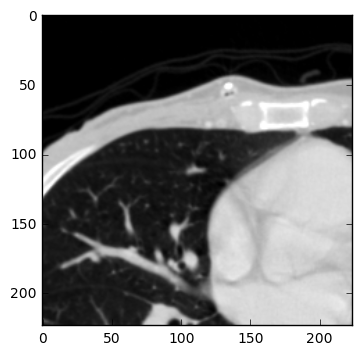

In [13]:
plt.imshow(test_image_good,cmap=plt.cm.gray)

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline

In [44]:
candidates_class1_empty_df = candidates_class1_df.ix[[517]]